# Data analysis

In [1]:
import os
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
#mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')
gdrive_path = "/content/drive/MyDrive/Tidy_Python_2025/"
%cd $gdrive_path

Mounted at /content/drive
/content/drive/MyDrive/Tidy_Python_2025


In [3]:
data_tidy_path = gdrive_path + 'tidy-data/'

In [4]:
crabs = pd.read_parquet(os.path.join(data_tidy_path, 'crabs.parquet'))

In [5]:
crabs.head()

,region,date,species,sex,stage,is_gravid,carapace_width,carapace_length,front_width,left_claw_length,right_claw_length,depth,associated_species,behaviour
0,Ria Alvor,2020-01-02,Uca olhanensis,female,juvenile,False,0.749001,0.672986,3.454545,0.969131,0.715282,7.0,"['Sea Sponge', 'Shrimp', 'Sea Star']",Collecting biofilm from sunken wood.
1,Ria Alvor,2020-01-02,Afruca farensis,NaN,sub_adult,None,3.176997,3.522727,3.454545,4.634476,3.790048,9.0,"['Snail', 'Sea Sponge', 'Algae', 'Sea Star']",Side-stepping along sandy coastal floor.
2,Ria Alvor,2020-01-02,Uca olhanensis,NaN,sub_adult,None,0.591866,0.568182,3.727273,0.748647,0.618259,11.0,['Snail'],Guarding eggs beneath body flap.
3,Ria Alvor,2020-01-02,Uca olhanensis,male,adult,None,3.426632,3.272727,3.727273,4.336083,3.471059,7.0,"['Sea Urchin', 'Polychaete Worm']",Swiftly dashing across exposed sand.
4,Ria Alvor,2020-01-02,Uca olhanensis,female,adult,False,3.126850,3.315087,3.636364,4.384256,3.536922,3.0,"['Hermit Crab', 'Sea Sponge', 'Jellyfish', 'Ba...",Gradual movement in cold conditions.


In [6]:
crabs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23824 entries, 0 to 23823
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   region              23824 non-null  category      
 1   date                23824 non-null  datetime64[ns]
 2   species             23824 non-null  category      
 3   sex                 21801 non-null  category      
 4   stage               23824 non-null  category      
 5   is_gravid           12019 non-null  object        
 6   carapace_width      23824 non-null  float64       
 7   carapace_length     23824 non-null  float64       
 8   front_width         23824 non-null  float64       
 9   left_claw_length    23824 non-null  float64       
 10  right_claw_length   23824 non-null  float64       
 11  depth               23824 non-null  float64       
 12  associated_species  23824 non-null  object        
 13  behaviour           23824 non-null  object    

## Statistical methods
- `scipy`
- `statsmodels`
- `scikit-learn`, ie `sklearn`

This tests whether there's a significant linear trend in a variable like `carapace_width` across the `ordered stage`.

In [7]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Treat 'stage' as numeric rank
crabs['stage_code'] = crabs['stage'].cat.codes

# Linear regression to test trend in carapace_width across stage
model = ols("carapace_width ~ stage_code", data=crabs).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         carapace_width   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     7517.
Date:                Wed, 02 Jul 2025   Prob (F-statistic):               0.00
Time:                        20:35:07   Log-Likelihood:                -42576.
No. Observations:               23824   AIC:                         8.516e+04
Df Residuals:                   23822   BIC:                         8.517e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0535      0.019     54.810      0.0

## GPT interpretation
This regression result shows a **strong, statistically significant linear relationship** between `stage_code` (your ordinal-coded stage variable) and `carapace_width`. Here's how to interpret the output:

---

### ✅ **Key Results**

#### 1. **Coefficient (slope):**

```text
stage_code     0.7690
```

This means that for each **unit increase in stage** (e.g., from juvenile to subadult to adult), the **carapace width increases by \~0.77 units**, on average. This supports that **stage has a meaningful, ordered effect** on body size.

---

#### 2. **Statistical Significance:**

```text
P>|t|      0.000
```

The p-value is effectively zero, meaning the relationship is **highly statistically significant** — the stage is **strongly predictive** of carapace width.

---

#### 3. **Model Fit:**

```text
R-squared: 0.240
```

This indicates that about **24% of the variation** in carapace width is explained by stage alone. That’s **moderate explanatory power** for a single variable in biological data — not trivial at all.

---

#### 4. **Intercept:**

```text
Intercept = 1.0535
```

When `stage_code` is 0 (likely the lowest/youngest stage), the model estimates a mean carapace width of about **1.05 units**.

---

#### 5. **Model Quality Diagnostics:**

* **F-statistic: 7517** (p ≈ 0): The overall regression is highly significant.
* **Durbin-Watson ≈ 1.77**: Indicates no serious autocorrelation in residuals.
* **Omnibus & JB p-values = 0**: Suggests residuals deviate from normality (though OLS is still robust here).
* **Skew = 0.97**, **Kurtosis = 4.76**: Slight positive skew and moderate tail heaviness in residuals.

---

### ✅ Conclusion

The results **validate the importance of the `stage` variable as an ordinal predictor** of `carapace_width`. There's a clear upward trend across stages, and the model shows it **captures biologically meaningful progression** in size.

Let me know if you want a [visual plot of this trend](f), [nonlinear comparison](f), or to [adjust for other covariates](f).


Jonckheere–Terpstra Test (non-parametric trend test)

### Principal Component Analysis (PCA)

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [13]:
numeric_cols = [
    'carapace_width',
    'carapace_length',
    'front_width',
    'left_claw_length',
    'right_claw_length',
    'depth'
]

In [14]:
# Drop rows with NaNs in numeric + label column (e.g., 'species')
df_pca = crabs.dropna(subset=numeric_cols + ['species', 'region'])

# Standardize the numeric features
X_scaled = StandardScaler().fit_transform(df_pca[numeric_cols])

In [15]:
#@title Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [16]:
# Create PCA DataFrame and add back species info
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['species'] = df_pca['species'].reset_index(drop=True)
pca_df['region'] = df_pca['region'].reset_index(drop=True)
pca_df.head()

,PC1,PC2,species,region
0,-2.208320,-0.175458,Uca olhanensis,Ria Alvor
1,1.037397,0.956300,Afruca farensis,Ria Alvor
2,-2.457859,1.420753,Uca olhanensis,Ria Alvor
3,0.838238,0.399865,Uca olhanensis,Ria Alvor
4,0.847559,-1.101331,Uca olhanensis,Ria Alvor


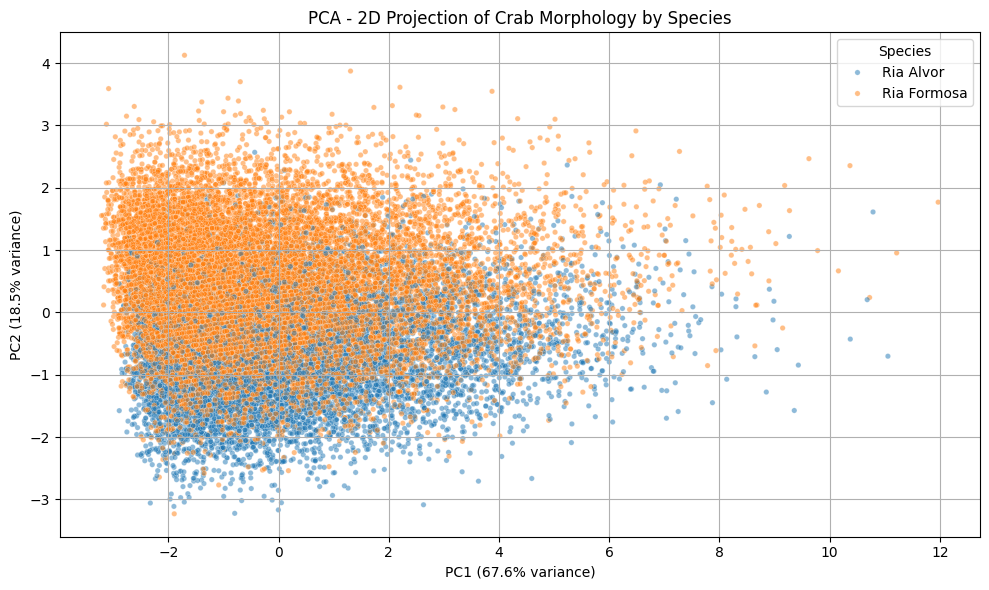

In [17]:
#@title Plot PCA components
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='region', alpha=0.5, s=15)
plt.title('PCA - 2D Projection of Crab Morphology by Species')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.legend(title='Species')
plt.grid(True)
plt.tight_layout()
plt.show()

### ANOVA

In [18]:
# Drop missing values (sex has NaNs)
df_anova = crabs[['carapace_width', 'sex']].dropna()

# Fit the model
model = smf.ols('carapace_width ~ C(sex)', data=df_anova).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(sex),1115.580885,1.0,417.896557,5.108102e-92
Residual,58192.744862,21799.0,NaN,NaN


`sum_sq` (Sum of Squares):
- 1127.29 of the variation in carapace_width is explained by sex.
- 53012.67 is unexplained (random noise, individual variation).

`df` (Degrees of Freedom):
- 1 for sex (only two groups: male and female).
- 20223 for the residual (number of observations - number of groups).

F (F-statistic):
- 430.03 → This is very large, meaning the between-group variability is far greater than within-group variability.

`PR(>F)` (p-value):
- 1.54e-94 → Extremely small, meaning the difference in means is statistically significant.

#### Exercise:
Run all pairs of numerical column vs all categorical and show `p-values` in the matrix


In [ ]:
from itertools import product

cat_columns =[
    'region', 'species', 'sex', 'stage'
]
numeric_cols.remove('depth [m]')

pairs = list(product(numeric_cols, cat_columns))
# pairs = [(x, y) for x in numeric_cols for y in cat_columns]
pairs

[('carapace_width', 'region'),
 ('carapace_width', 'species'),
 ('carapace_width', 'sex'),
 ('carapace_width', 'stage'),
 ('carapace_length', 'region'),
 ('carapace_length', 'species'),
 ('carapace_length', 'sex'),
 ('carapace_length', 'stage'),
 ('front_width', 'region'),
 ('front_width', 'species'),
 ('front_width', 'sex'),
 ('front_width', 'stage'),
 ('left_claw_length', 'region'),
 ('left_claw_length', 'species'),
 ('left_claw_length', 'sex'),
 ('left_claw_length', 'stage'),
 ('right_claw_length', 'region'),
 ('right_claw_length', 'species'),
 ('right_claw_length', 'sex'),
 ('right_claw_length', 'stage')]

In [ ]:
def anova_table(df, num_col, cat_col):
    df_anova = df[[num_col, cat_col]].dropna()
    model = smf.ols(f'{num_col} ~ C({cat_col})', data=df_anova).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    return anova_table

In [ ]:
for pair in pairs:
    # print(pair)
    anova_result = anova_table(crabs, *pair)
    pval = anova_result.loc[f'C({pair[1]})', 'PR(>F)']
    print(f'pair: {pair}, p-value: {pval}')

pair: ('carapace_width', 'region'), p-value: 5.100349946552572e-16
pair: ('carapace_width', 'species'), p-value: 2.8775670870844186e-12
pair: ('carapace_width', 'sex'), p-value: 1.539555841208505e-94
pair: ('carapace_width', 'stage'), p-value: 0.0
pair: ('carapace_length', 'region'), p-value: 2.675685268898375e-17
pair: ('carapace_length', 'species'), p-value: 1.3121847766314972e-11
pair: ('carapace_length', 'sex'), p-value: 1.7571527658573236e-129
pair: ('carapace_length', 'stage'), p-value: 0.0
pair: ('front_width', 'region'), p-value: 0.0
pair: ('front_width', 'species'), p-value: 5.470815106842314e-07
pair: ('front_width', 'sex'), p-value: 0.07618576684584975
pair: ('front_width', 'stage'), p-value: 0.6041293502951632
pair: ('left_claw_length', 'region'), p-value: 6.504229294130589e-16
pair: ('left_claw_length', 'species'), p-value: 3.3882466993166005e-13
pair: ('left_claw_length', 'sex'), p-value: 2.7684140943472115e-94
pair: ('left_claw_length', 'stage'), p-value: 0.0
pair: ('rig

## Time series

In [19]:
crabs['species'].value_counts()

,count
species,
Uca olhanensis,12754
Afruca farensis,9126
Ucides alvorensis,1944


In [20]:
uca_counts = crabs.groupby(['species', 'date', 'region']).size()

/tmp/ipython-input-20-1222202361.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  uca_counts = crabs.groupby(['species', 'date', 'region']).size()


In [21]:
time_series = uca_counts.unstack(level=0).unstack(level=1)

In [22]:
time_series.columns

MultiIndex([(  'Afruca farensis',   'Ria Alvor'),
            (  'Afruca farensis', 'Ria Formosa'),
            (   'Uca olhanensis',   'Ria Alvor'),
            (   'Uca olhanensis', 'Ria Formosa'),
            ('Ucides alvorensis',   'Ria Alvor'),
            ('Ucides alvorensis', 'Ria Formosa')],
           names=['species', 'region'])

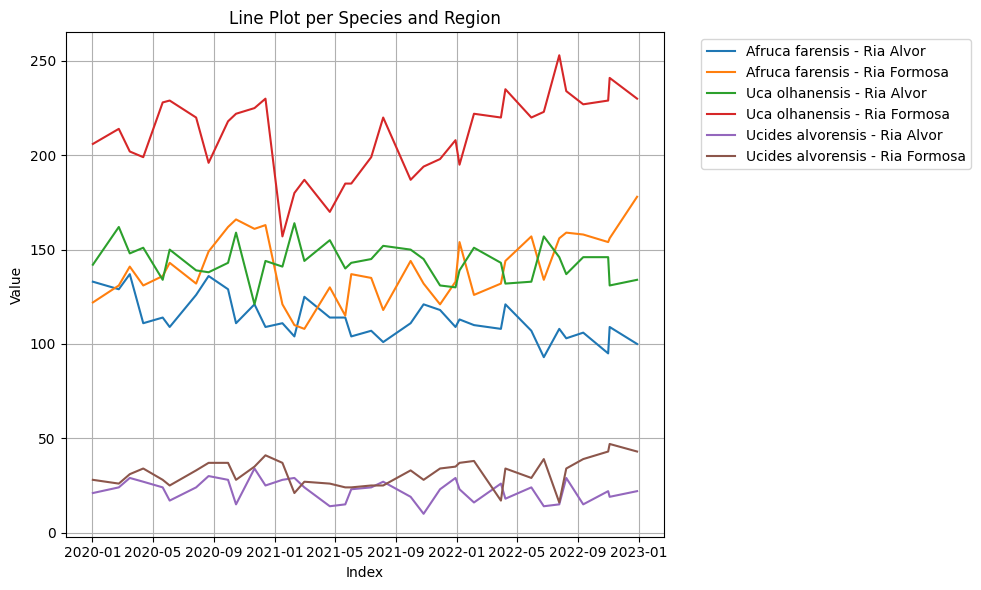

In [23]:
# Assume df_lines.columns is a MultiIndex with ('species', 'region')
fig, ax = plt.subplots(figsize=(10, 6))

for col in time_series.columns:
    species, region = col
    ax.plot(time_series.index, time_series[col], label=f"{species} - {region}")

ax.set_xlabel("Index")  # or use e.g. 'Date' if your index is time
ax.set_ylabel("Value")
ax.set_title("Line Plot per Species and Region")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

/tmp/ipython-input-24-1964006441.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  time_series_resampled = time_series.resample('M').mean()


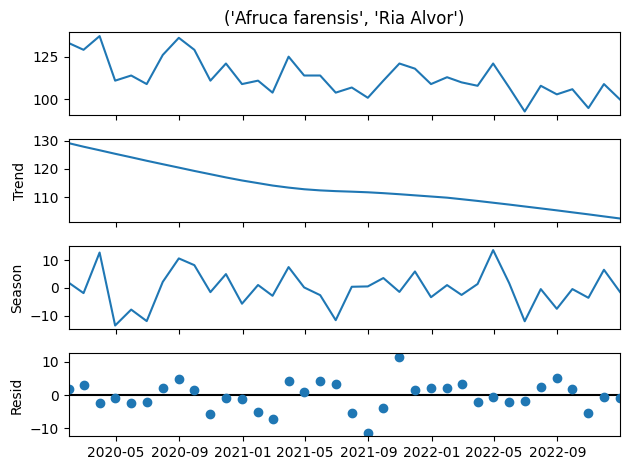

In [24]:
from statsmodels.tsa.seasonal import STL

# Resample the time series to a monthly frequency
time_series_resampled = time_series.resample('M').mean()

# Apply STL decomposition to the resampled time series
# Choose a seasonal period appropriate for your data (e.g., 12 for monthly data)
# You might need to adjust the seasonal period based on your domain knowledge or by inspecting the data
stl = STL(time_series_resampled['Afruca farensis', 'Ria Alvor'], seasonal=7)
res = stl.fit()
fig = res.plot()
plt.show()

## Cluster Behaviours


In [25]:
from sentence_transformers import SentenceTransformer

In [26]:
model = SentenceTransformer('all-MiniLM-L6-v2')  # Small, fast, good quality

embeddings = model.encode(crabs['behaviour'].unique())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [41]:
embeddings

array([[-0.06595841,  0.04002056,  0.04560459, ..., -0.09102523,
        -0.00284931,  0.01121238],
       [-0.00085099,  0.02972325,  0.09094916, ..., -0.00186126,
        -0.04346503,  0.04569922],
       [ 0.00571296,  0.10159243,  0.01370336, ...,  0.03463693,
         0.09423129,  0.03049887],
       ...,
       [-0.03358101,  0.06536556,  0.07306654, ..., -0.02951738,
         0.03891019,  0.05837635],
       [ 0.06204555,  0.0337689 , -0.00890248, ...,  0.10014624,
        -0.07802252,  0.01749283],
       [ 0.05252184,  0.07111633,  0.00269169, ...,  0.03816232,
        -0.0259767 ,  0.00237573]], dtype=float32)

In [42]:
embeddings.shape

(68, 384)

In [43]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

behaviours = crabs['behaviour'].unique()
idx = 0  # e.g., first behaviour
sims = cosine_similarity([embeddings[idx]], embeddings)[0]
top_k = np.argsort(sims)[::-1][1:6]  # skip self

print(f"Query: {behaviours[idx]}")
for i in top_k:
    print(f"  ↳ Similar: {behaviours[i]} (cosine={sims[i]:.2f})")

Query: Collecting biofilm from sunken wood.
  ↳ Similar: Consuming algae scraped from barnacles. (cosine=0.45)
  ↳ Similar: Sifting through sediment for scraps. (cosine=0.44)
  ↳ Similar: Harvesting food beneath floating debris. (cosine=0.42)
  ↳ Similar: Clambering up submerged tree trunks. (cosine=0.42)
  ↳ Similar: Burrowing into soft, sandy sediment. (cosine=0.41)


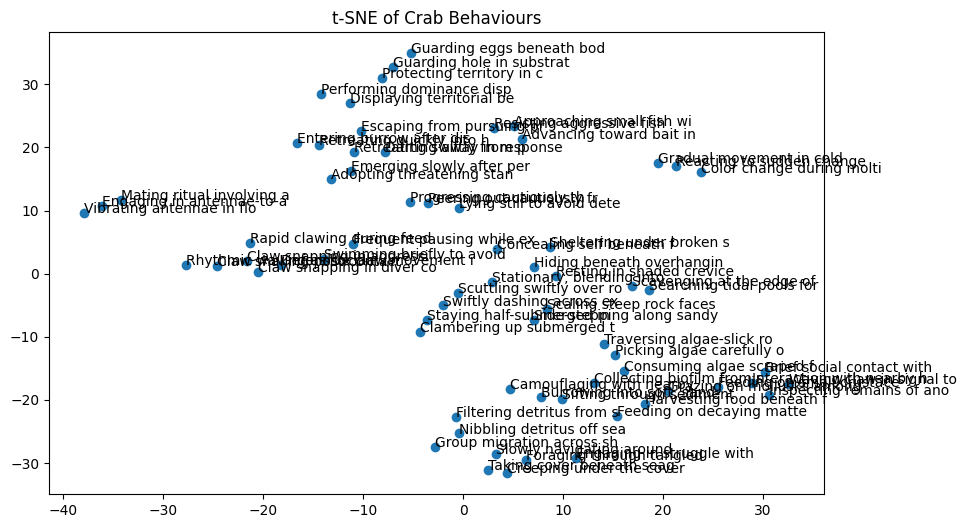

In [44]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

reduced = TSNE(n_components=2, perplexity=5).fit_transform(embeddings)
plt.figure(figsize=(10, 6))
plt.scatter(reduced[:, 0], reduced[:, 1])

for i, txt in enumerate(behaviours):
    plt.annotate(txt[:25], (reduced[i, 0], reduced[i, 1]))  # truncate for readability

plt.title("t-SNE of Crab Behaviours")
plt.show()

In [31]:
from sklearn.cluster import KMeans

In [32]:
help(KMeans)

Help on class KMeans in module sklearn.cluster._kmeans:

class KMeans(_BaseKMeans)
 |  KMeans(n_clusters=8, *, init='k-means++', n_init='auto', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd')
 |  
 |  K-Means clustering.
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, default=8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |      For an example of how to choose an optimal value for `n_clusters` refer to
 |      :ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.
 |  
 |  init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
 |      Method for initialization:
 |  
 |      * 'k-means++' : selects initial cluster centroids using sampling             based on an empirical probability distribution of the points'             contribution to t

In [39]:
num_clusters = 5
clustering_model = KMeans(n_clusters=num_clusters, random_state=42,
                          init='k-means++',
                          n_init=20,
                          max_iter=500,
                          verbose=1,
                          tol=1e-5,
                          )
clustering_model.fit(embeddings)
cluster_assignment = clustering_model.labels_

for i, cluster_id in enumerate(cluster_assignment[:20]):
    print(f"Text: {crabs['behaviour'][i]} => Cluster {cluster_id}")

Initialization complete
Iteration 0, inertia 74.20482635498047.
Iteration 1, inertia 42.40169906616211.
Iteration 2, inertia 42.021690368652344.
Iteration 3, inertia 41.80483627319336.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 72.78131103515625.
Iteration 1, inertia 42.55152893066406.
Iteration 2, inertia 42.27767562866211.
Iteration 3, inertia 41.94952392578125.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 71.6830062866211.
Iteration 1, inertia 42.37681579589844.
Iteration 2, inertia 41.94307327270508.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 70.27285766601562.
Iteration 1, inertia 41.808448791503906.
Iteration 2, inertia 41.67939758300781.
Iteration 3, inertia 41.452178955078125.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 71.92550659179688.
Iteration 1, inertia 42.928775787353516.
Iteration 2, 

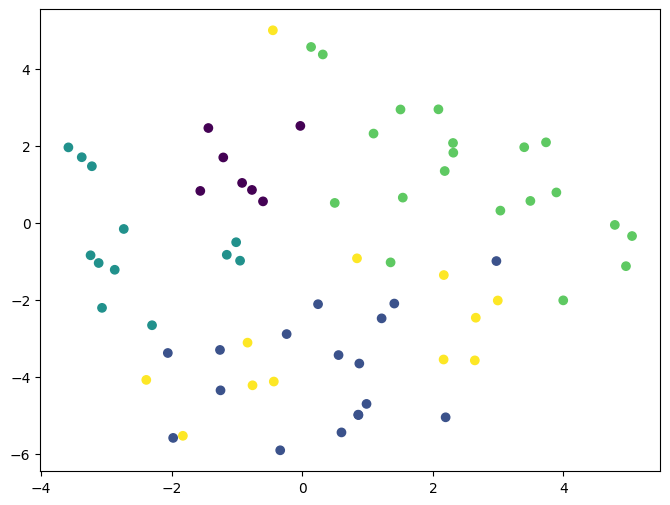

In [40]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(8,6))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=cluster_assignment, cmap='viridis')
# for i, txt in enumerate(crabs['behaviour']):
#     plt.annotate(txt[:15]+'...', (embeddings_2d[i,0], embeddings_2d[i,1]))
plt.show()

In [29]:
#@title this does not work because of precise overlaps
crabs['behaviour'].value_counts()

,count
behaviour,
Resting in shaded crevice along cliff.,400
Engaging in struggle with seaweed entanglement.,388
Performing dominance display by body lifting.,385
Camouflaging with nearby mud.,377
Side-stepping along sandy coastal floor.,375
...,...
Picking algae carefully off rock faces.,330
Advancing toward bait in water.,329
Darting away in response to sudden shadow.,323


## Predictive models
- predict stage from the measures
- select predictive features

## Pipelines

In [ ]:
# Run the pipeline using .pipe()

# Step 2: Run PCA, add PC1, PC2 columns
def run_pca(df, numeric_cols=None):
    if numeric_cols is None:
        numeric_cols = ['carapace_width', 'carapace_length', 'front_width', 'depth [m]']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[numeric_cols])

    pca = PCA(n_components=2)
    pcs = pca.fit_transform(X_scaled)

    df = df.copy()
    df['PC1'] = pcs[:, 0]
    df['PC2'] = pcs[:, 1]

    print("\nExplained variance by PCA components:")
    print(pca.explained_variance_ratio_)

    return df


df = (crabs
      .pipe(run_pca)
      .pipe(anova_table, *pairs[0])
)


Explained variance by PCA components:
[0.53285693 0.26928761]


In [ ]:
df

,sum_sq,df,F,PR(>F)
C(region),177.884316,1.0,65.856727,5.100350e-16
Residual,59637.154375,22079.0,NaN,NaN
